In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.distributions as dist
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

from tqdm.notebook import trange


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [3]:
class G(nn.Module):
    def __init__(self, z_dim, x_shape, hidden_dim=500):
        super().__init__()
        
        self.x_shape = x_shape
        self.x_dim = np.prod(x_shape)
        self.z_dim = z_dim
        
        self.net = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.x_dim),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.net(input).view(-1, *self.x_shape)

In [4]:
class D(nn.Module):
    def __init__(self, x_shape, hidden_dim=500):
        super().__init__()
        
        self.x_dim = np.prod(x_shape)
        
        self.net = nn.Sequential(
            nn.Linear(self.x_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, input):
        return self.net(input.view(len(input), self.x_dim)).squeeze(-1)

In [28]:
z_dim = 10

n_epoch = 30
batch_size=200
lr = 1e-3

device = torch.cuda.current_device()

dataset = datasets.MNIST('.', download=True, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
x_shape = (1, 28, 28)
make_real_y = lambda size: torch.ones(size)
make_fake_y = lambda size: torch.zeros(size)

g = G(z_dim, x_shape).to(0)
d = D(x_shape).to(0)

d_optimizer = torch.optim.Adam(d.parameters(), lr=lr, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(g.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

In [29]:
real_d_losses, fake_d_losses, g_losses = [], [], []
z_examples = torch.randn(8*8, z_dim).to(device)
epoch_fake_x_examples = []

for epoch_i in trange(n_epoch):
    epoch_fake_x_examples.append(g(z_examples))
    
    for real_x, _ in loader:
        d.zero_grad()
        
        # discriminator for real data
        real_x = real_x.to(device)
        real_pred_y = d(real_x)
        real_y = make_real_y(len(real_x)).to(device)
        
        real_d_loss = criterion(real_pred_y, real_y)
        real_d_loss.backward()

        # discriminator for fake data
        z = torch.randn(len(real_x), z_dim, device=device)
        fake_x = g(z)
        fake_pred_y = d(fake_x.detach())
        fake_y = make_fake_y(len(real_x)).to(device)
        
        fake_d_loss = criterion(fake_pred_y, fake_y)
        fake_d_loss.backward()
        
        d_optimizer.step()

        # generator
        g.zero_grad()
        fake_pred_y = d(fake_x).view(-1)
        g_loss = criterion(fake_pred_y, real_y)
        g_loss.backward()
        g_optimizer.step()
    
    real_d_losses.append(real_d_loss.item())
    fake_d_losses.append(fake_d_loss.item())
    g_losses.append(g_loss.item())
torch.save({'g': g.state_dict(), 'd': d.state_dict()}, 'gan.pt')

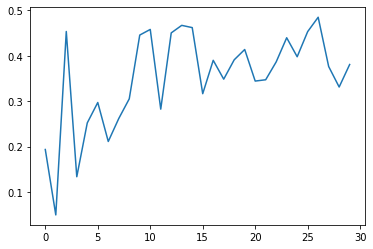

In [30]:
plt.plot(range(len(real_d_losses)), real_d_losses)

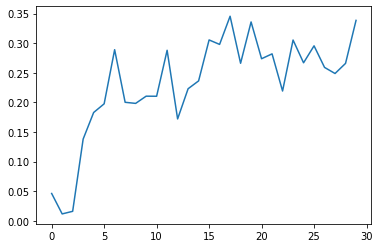

In [31]:
plt.plot(range(len(fake_d_losses)), fake_d_losses)

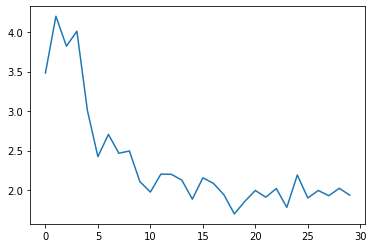

In [32]:
plt.plot(range(len(g_losses)), g_losses)

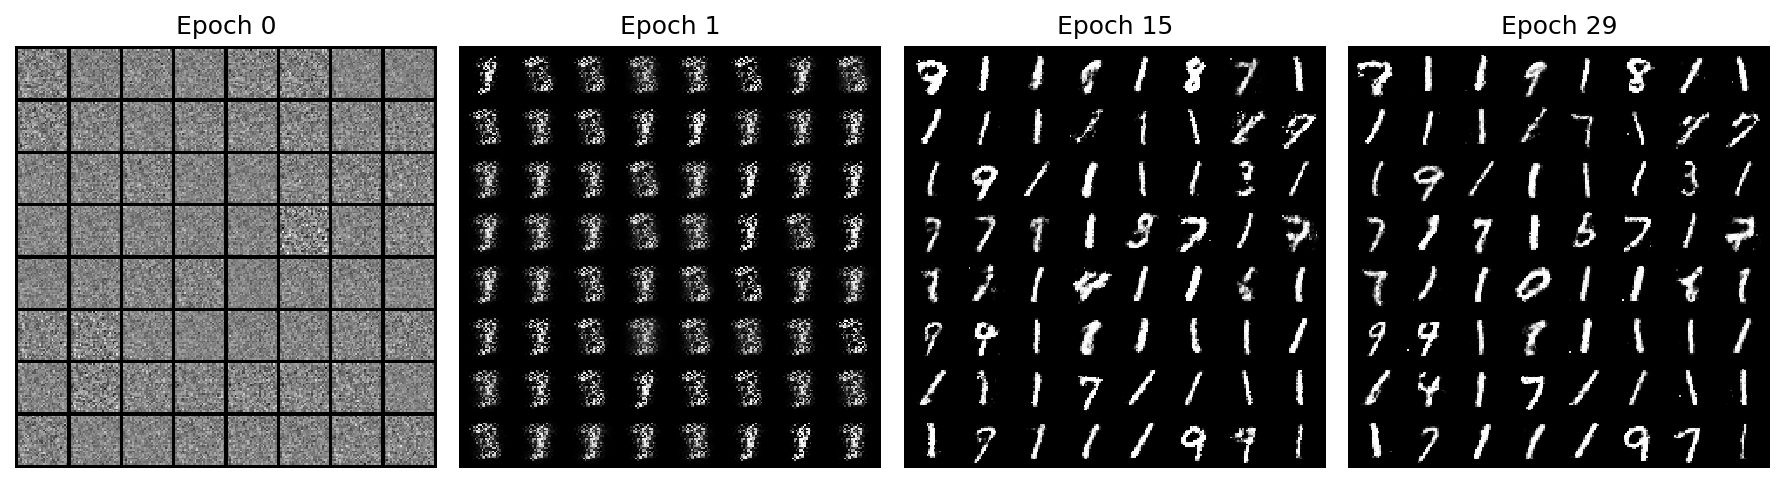

In [35]:
epochs = [0, 1, 15, 29]

fig, axes = plt.subplots(1, len(epochs), figsize=(12, 6), dpi=150)
imgs = [epoch_fake_x_examples[epoch] for epoch in epochs]
titles = [f'Epoch {epoch}' for epoch in epochs]

for title, axis, img in zip(titles, axes, imgs):
    axis.imshow(np.transpose(
        vutils.make_grid(img, padding=2, normalize=True).detach().cpu(),(1,2,0)
    ))
    axis.axis('off')
    axis.set_title(title)
fig.tight_layout()
